# A simple console

In [1]:
L = 100.0  # length of the console
w, h = 10.0, 10.0  # width and height of the rectangular cross section
F = -100.0  # value of the vertical load at the free end
E = 210000.0  # Young's modulus
nu = 0.3  # Poisson's ratio

In [2]:
# cross section
A = w * h  # area
Iy = w * h**3 / 12  # second moment of inertia around the y axis
Iz = w * h**3 / 12  # second moment of inertia around the z axis
Ix = Iy + Iz  # torsional inertia

In [3]:
import numpy as np

EI = E * Iy
sol_exact = F * L**3 / (3 * EI)
tol = np.abs(sol_exact / 1000)
sol_exact

-0.19047619047619047

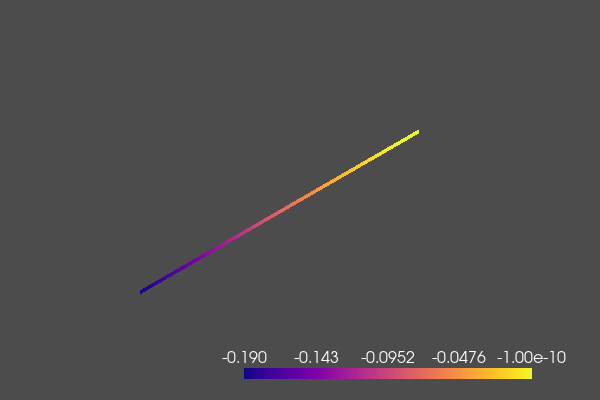

In [5]:
from sigmaepsilon.fem import Structure, LineMesh, PointData
from neumann.linalg import linspace, Vector
from polymesh.space import StandardFrame, PointCloud
from polymesh.utils.space import frames_of_lines
from sigmaepsilon.fem.cells import B2 as Beam

G = E / (2 * (1 + nu))
Hooke = np.array(
    [[E * A, 0, 0, 0], [0, G * Ix, 0, 0], [0, 0, E * Iy, 0], [0, 0, 0, E * Iz]]
)

# space
GlobalFrame = StandardFrame(dim=3)

# mesh
nElem = 20  # number of finite elements to use
p0 = np.array([0.0, 0.0, 0.0])
p1 = np.array([L, 0.0, 0.0])
coords = linspace(p0, p1, nElem + 1)
coords = PointCloud(coords, frame=GlobalFrame).show()
topo = np.zeros((nElem, 2), dtype=int)
topo[:, 0] = np.arange(nElem)
topo[:, 1] = np.arange(nElem) + 1

# support at the leftmost, load at the rightmost node
loads = np.zeros((coords.shape[0], 6))
fixity = np.zeros((coords.shape[0], 6)).astype(bool)
global_load_vector = Vector([0.0, 0, F], frame=GlobalFrame).show()
loads[-1, :3] = global_load_vector
fixity[0, :] = True

# pointdata
pd = PointData(coords=coords, frame=GlobalFrame, loads=loads, fixity=fixity)

# celldata
frames = frames_of_lines(coords, topo)
cd = Beam(topo=topo, material=Hooke, frames=frames)

# set up mesh and structure
mesh = LineMesh(pd, cd, frame=GlobalFrame)
structure = Structure(mesh=mesh)
structure.linsolve()

# Postprocessing: displace the mesh
structure.nodal_dof_solution(store="dofsol")
dofsol = structure.mesh.pd["dofsol"].to_numpy()[:, :3]
local_dof_solution = dofsol[-1, :3]
sol_fem_1d_B2 = local_dof_solution[2]
sol_fem_1d_B2

mesh.config["pyvista", "plot", "scalars"] = dofsol[:, 2]
mesh.config["pyvista", "plot", "line_width"] = 4
mesh.pvplot(
    notebook=True,
    jupyter_backend="static",
    window_size=(600, 400),
    config_key=["pyvista", "plot"],
    cmap="plasma",
    theme="document",
)